In [1]:
import re
import random
from operator import itemgetter
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from scipy.stats import randint, uniform, loguniform
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

SEED = 42

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')

# The dataset

In [3]:
loading_data_params = {"remove": ("headers", "footers", "quotes"),
                       "return_X_y": True,
                       "random_state": SEED}

train = fetch_20newsgroups(data_home="data/train", subset="train")
X_train, y_train = fetch_20newsgroups(data_home="data/train", subset="train", **loading_data_params)
X_test, y_test = fetch_20newsgroups(data_home="data/test", subset="test", **loading_data_params)

## Content

In [4]:
print(train.DESCR[26:395])
print(train.DESCR[846:1050])


The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1
Features                  text


In [5]:
labels = dict(zip(range(20), train.target_names))
pd.DataFrame.from_dict(labels, orient="index", columns=["target_name"])

,target_name
0,alt.atheism
1,comp.graphics
2,comp.os.ms-windows.misc
3,comp.sys.ibm.pc.hardware
4,comp.sys.mac.hardware
5,comp.windows.x
6,misc.forsale
7,rec.autos
8,rec.motorcycles
9,rec.sport.baseball


In [19]:
# for convenient data browsing
def display_random_sample(data, target_variable, labels, n_samples=1, target_class=None):
    """Display random sample(s) from all the data or from a selected class"""
    
    if target_class is not None:
        filtered_indices = [i for i, label in enumerate(target_variable) if label == target_class]
        if not filtered_indices:
            print(f"No samples found for class {target_class}")
            return
        data = list(itemgetter(*filtered_indices)(data))
        target_variable = list(itemgetter(*filtered_indices)(target_variable))
    
    sampled_indices = random.sample(range(len(data)), k=n_samples)
    
    for i in sampled_indices:
        label = labels[target_variable[i]]
        print(f"Label: {label}\n\nMessage:\n{data[i]}\n")

display_random_sample(X_train, y_train, labels, n_samples=1, target_class=None)

Label: talk.politics.mideast

Message:


It's hard to beat a car-bomb with a suicidal driver in getting 
right up to the target before blowing up.  Even booby-traps and
radio-controlled bombs under cars are pretty efficient killers.  
You have a point.   


Is this part of your Islamic value-system?


Had Israeli methods been anything like this, then Iraq wouldn've been
nuked long ago, entire Arab towns deported and executions performed by
the tens of thousands.  The fact is, though, that Israeli methods
aren't even 1/10,000th as evil as those which are common and everyday
in Arab states.


"Israeli soil"????  Brad/Ali!  Just wait until the Ayatollah's
thought-police get wind of this.  It's all "Holy Muslim Soil (tm)".
Have you forgotten?  May Allah have mercy on you now.





## Initial cleaning

In [8]:
def check_empty_samples(X_train, X_test):
    """"""
    empty_train_indices = [idx for idx, string in enumerate(X_train) if string in ["", " "]]
    empty_test_indices = [idx for idx, string in enumerate(X_test) if string in ["", " "]]
    
    return empty_train_indices, empty_test_indices

empty_train_indices, empty_test_indices = check_empty_samples(X_train, X_test)
print(f"X_train: {len(empty_train_indices)} empty strings\nX_test: {len(empty_test_indices)} empty strings")

X_train: 226 empty strings
X_test: 163 empty strings


In [9]:
def remove_empty_samples(X: List[str], y: np.ndarray, indices: List[int]):
    """Remove samples with empty data"""
    # X, y = X.copy(), y.copy()
    for idx in reversed(indices):
        del X[idx]
        y = np.delete(y, idx)

    return X, y
    
X_train, y_train = remove_empty_samples(X_train, y_train, empty_train_indices)
X_test, y_test = remove_empty_samples(X_test, y_test, empty_test_indices)

empty_train_indices, empty_test_indices = check_empty_samples(X_train, X_test)
print(f"X_train: {len(empty_train_indices)} empty strings\nX_test: {len(empty_test_indices)} empty strings")

X_train: 0 empty strings
X_test: 0 empty strings


## Class distribution

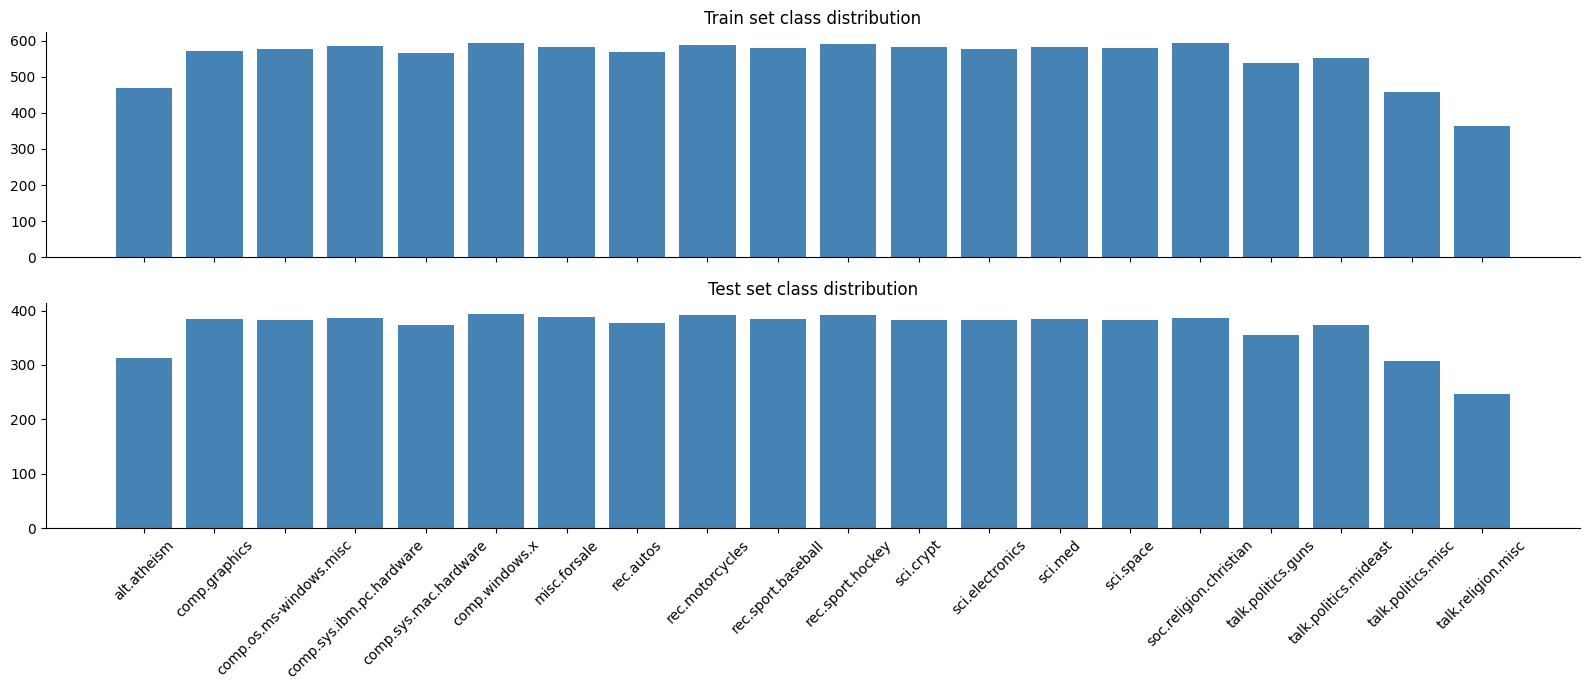

In [10]:
unique, counts_train = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

fig, axs = plt.subplots(2, 1, figsize=(16, 7), sharex=True)
axs[0].bar(train.target_names, counts_train, color="steelblue")
axs[0].set_title("Train set class distribution")
axs[1].bar(train.target_names, counts_test, color="steelblue")
axs[1].set_title("Test set class distribution")
axs[1].set_xticks(ticks=unique, labels=train.target_names, rotation=45)
plt.tight_layout();

# Data preparing and ML experiments

## Data preparing

In [11]:
class DataCleaner:

    def __init__(self,
                 to_remove_patterns: List[str],
                 to_remove_words: List[str] = [],
                 token_pattern: str = r"(?u)\b\w[\w']*\b"
                ):
        
        self.to_remove_patterns = to_remove_patterns
        self.to_remove_words = to_remove_words
        self.token_pattern = token_pattern
        self.stop_words = stopwords.words("english")
        self.lemmatizer = WordNetLemmatizer()

    def remove_substrings_from_patterns(self):
        "Remove substrings found as unwanted token patterns."
        for pattern in self.to_remove_patterns:
            self.data = [pattern.sub("", message) for message in self.data]

        return self
    
    def remove_substring_from_list(self):
        """Tokenize, remove unwanted words and lowercase all."""
        
        pre_cleaned = []
        
        for message in self.data:
            tokens = re.findall(self.token_pattern, message)
            cleaned_message = [w.lower() for w in tokens if w.lower() not in self.stop_words + self.to_remove_words]
            pre_cleaned.append(cleaned_message)

        self.data = pre_cleaned
    
        return self       
    
    def lemmatize_data(self):
        """Lemmatize tokenized messages and join into strings."""
    
        for i in range(len(self.data)):
            lemmatized_message = [self.lemmatizer.lemmatize(token) for token in self.data[i]]
            self.data[i] = " ".join(lemmatized_message)
    
        return self

    def transform(self, data: List[str]):
        self.data = data.copy()
        self.remove_substrings_from_patterns()
        self.remove_substring_from_list()
        self.lemmatize_data()
        
        return self.data

In [12]:
email_pattern = re.compile("[\w\.]+@\w+\.\w+[\w\.]*")
nntp_pattern = re.compile(r"\b\w*(?:nntp|NNTP)\w*\b")
num_seq_pattern = re.compile(r'\b\d+\b')
words_to_remove = ["re", "subject", "organization", "lines", "from", "date",
                   "references", "message", "id", "voice", "fax", "email", "mail",
                   "i'm", "i've", "i'd", "can't", "can"]

cleaner = DataCleaner(to_remove_patterns=[email_pattern,
                                          nntp_pattern,
                                          num_seq_pattern],
                      to_remove_words=words_to_remove)

cleaned_X_train = cleaner.transform(X_train)
cleaned_X_test = cleaner.transform(X_test)

In [30]:
vectorizer = TfidfVectorizer()
print(f"Number of unigram features before cleaning: {len(vectorizer.fit(X_train).get_feature_names_out())}\nAfter cleaning and lemmatization: {len(vectorizer.fit(cleaned_X_train).get_feature_names_out())}")

Number of unigram features before cleaning: 101631
After cleaning and lemmatization: 88781


In [13]:
bold = "\033[1m"
end_bold = "\033[0m"
for i in random.sample(range(len(X_train)), k=2):
    print(f"{bold}Original message:{end_bold}\n:", X_train[i])
    print(f"{bold}Cleaned message:{end_bold}\n:", cleaned_X_train[i])
    print("-"*72)

Original message:
: Packer Bell 12MHZ 286
  * 5 16bit expansion slots
  * 2 5.25" external drive bays (floppies)
  * 1 3.5" internal drive bay (hard-drive)
  * 1.44MB 3.5" floppy drive
  * 1MB of RAM
 
$140 or Best offer (including shipping)
 
Segate 32MB ST138N SCSI Hard-drive
  * Great shape
  * Controller
  * 32MB
  * 3.5" format
Cleaned message:
: packer bell 12mhz 16bit expansion slot external drive bay floppy internal drive bay hard drive 44mb floppy drive 1mb ram best offer including shipping segate 32mb st138n scsi hard drive great shape controller 32mb format
------------------------------------------------------------------------
Original message:
: 
One rule of thumb is that if a person is making the claim, they are
wrong.  I was just reading John 14 this morning (I think that is the
right chapter, anyway it is close and I don't have a Bible at work to
check with.) and in it Jesus is talking to his disciples about his
impending death and he says that he will be going away an

## Pipeline hyperparameters optimization

In [22]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("selector", "passthrough"),
    ("model", "passthrough")
])

chi2_selection_grid = {
    "vectorizer__stop_words": [None],
    "vectorizer__ngram_range": [(1, 1)],
    "selector": [SelectKBest(chi2)],
    "selector__k": randint(10000, 80000)
}

vectorizer_selection_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__stop_words": ["english"],
    "vectorizer__min_df": randint(1, 5),
    "vectorizer__max_df": uniform(0.1, 0.7)
}

mnb_base_grid = {
    "model": [MultinomialNB()],
    "model__alpha": uniform(0, 1),
}

svm_base_grid = {
    "model": [SVC(random_state=SEED)],
    "model__kernel": ["linear", "rbf"],
    "model__C": loguniform(1e-3, 1e2),
}

cleaned_data_grid = [
    {
        **mnb_base_grid,
        **chi2_selection_grid
    },
    {
        **svm_base_grid,
        **chi2_selection_grid
    }
]

full_data_grid = [
    {
        **mnb_base_grid,
        **vectorizer_selection_grid
    },
    {
        **svm_base_grid,
        **vectorizer_selection_grid
    }
]

In [28]:
cv_scheme = KFold(n_splits=5, shuffle=True, random_state=SEED)

for X, y, grid in zip([X_train, cleaned_X_train],
                      [y_train, y_train],
                      [full_data_grid, cleaned_data_grid]):

    optimizer = RandomizedSearchCV(pipeline,
                                   grid,
                                   scoring="f1_macro",
                                   n_iter=10,
                                   cv=cv_scheme,
                                   n_jobs=-1,
                                   error_score="raise"
                                   )
    
    optimizer.fit(X, y)
    print(optimizer.best_score_)
    print(optimizer.best_params_)
    print("--------------------")

0.7555151473275618
{'model': MultinomialNB(), 'model__alpha': 0.08553634779456265, 'vectorizer__max_df': 0.5911198831879184, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'}
--------------------
0.7470314977937692
{'model': SVC(random_state=42), 'model__C': 1.1476873240022365, 'model__kernel': 'rbf', 'selector': SelectKBest(score_func=<function chi2 at 0x7c9e25b188b0>), 'selector__k': 66210, 'vectorizer__stop_words': None}
--------------------


0.6965666983308454


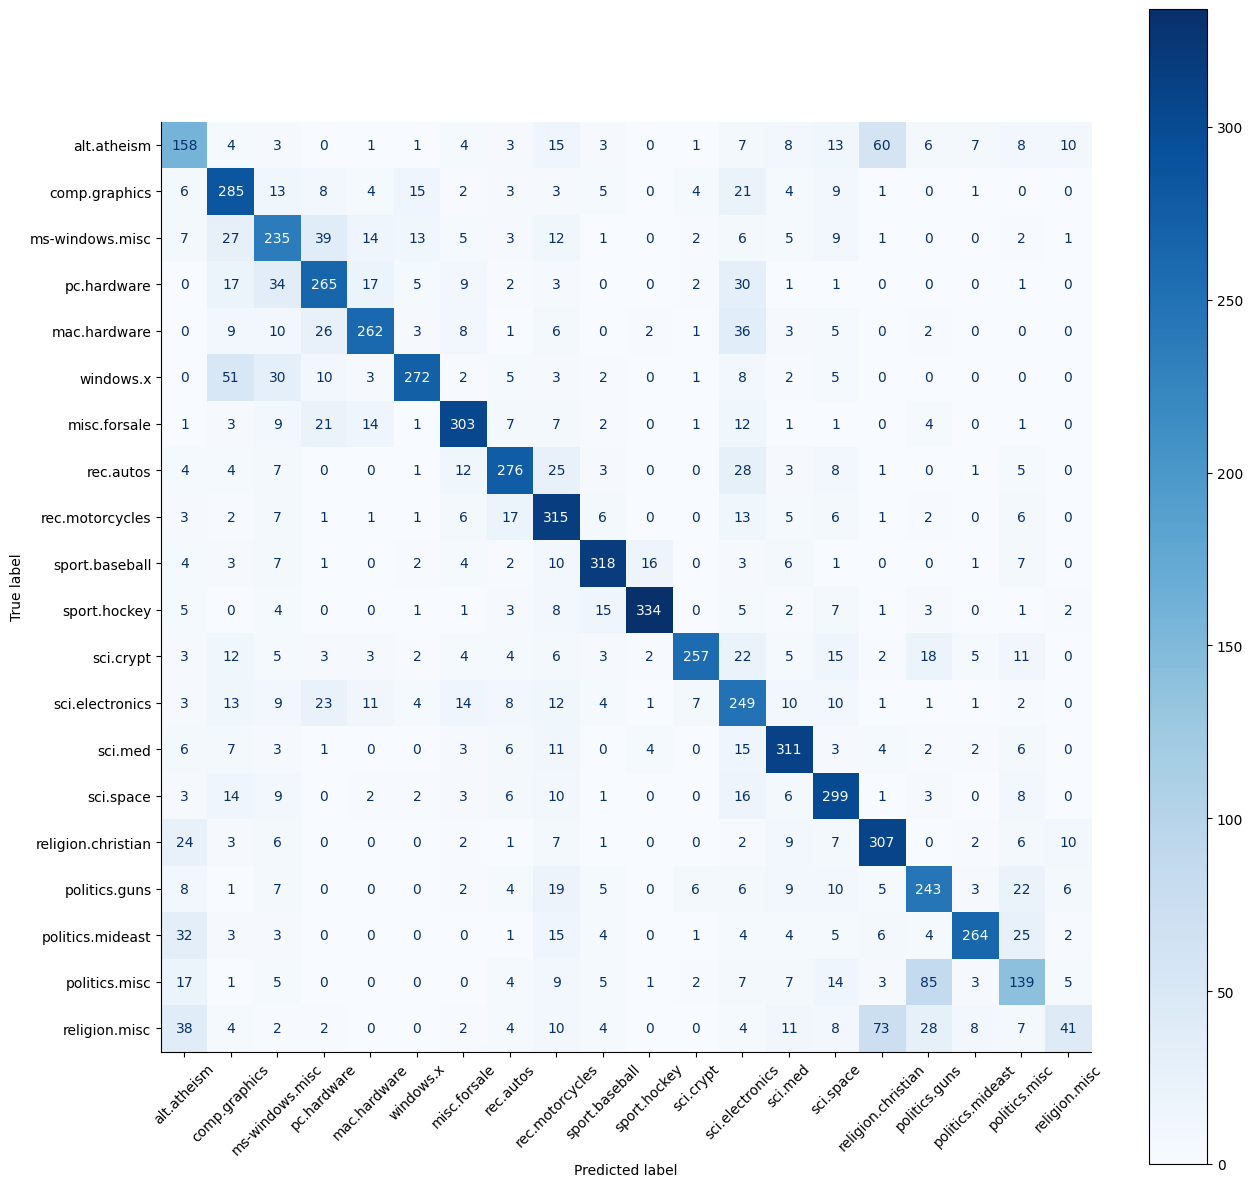

In [29]:
y_pred = optimizer.predict(cleaned_X_test)
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ConfusionMatrixDisplay(cm, display_labels=[".".join((l.split(".")[-2:])) for l in train.target_names]).plot(cmap="Blues", ax=ax)
plt.xticks(rotation=45);